<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/ELM/FFNN_ELM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# diabetes_ffnn_elm.py
# ------------------------------------------------------------
# Binary classification for Diabetes dataset with FFNN and ELM
# Expects "diabetes.csv" with columns:
# Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin,
# BMI, PedigreeFun, Age, Outcome
# Target column: Outcome (0/1)
# ------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Ridge

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

# ---------------------------
# 1) Load data
# ---------------------------
CSV_PATH = "heart.csv"
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# Ensure target present
assert "target" in df.columns, "Target column 'Outcome' not found in the CSV."

# ---------------------------
# 2) Feature/Target split
# ---------------------------
target = "target"
feature_cols = [c for c in df.columns if c != target]
X = df[feature_cols].copy()
y = df[target].astype(int).copy()

# Identify numeric vs categorical automatically
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]


In [11]:
# ---------------------------
# 3) Train/Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ---------------------------
# 4) Preprocessing
# ---------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

In [12]:
# ---------------------------
# 5) ELM Classifier (custom)
# ---------------------------
class ELMClassifier(BaseEstimator, ClassifierMixin):
    """
    Extreme Learning Machine (binary) with:
      - Random input -> hidden weights (fixed)
      - Activation: relu/sigmoid/tanh/linear
      - Output weights via ridge regression
    """
    def __init__(self, n_hidden=25, activation="relu", alpha=1e-2, random_state=RANDOM_STATE):
        self.n_hidden = n_hidden
        self.activation = activation
        self.alpha = alpha
        self.random_state = random_state

    def _act(self, Z):
        if self.activation == "relu":
            return np.maximum(0.0, Z)
        elif self.activation == "sigmoid":
            return 1.0 / (1.0 + np.exp(-Z))
        elif self.activation == "tanh":
            return np.tanh(Z)
        elif self.activation == "linear":
            return Z
        else:
            raise ValueError(f"Unknown activation: {self.activation}")

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X)
        y = np.asarray(y).astype(float).reshape(-1, 1)
        n_features = X.shape[1]

        self.W_ = rng.normal(loc=0.0, scale=1.0, size=(n_features, self.n_hidden))
        self.b_ = rng.normal(loc=0.0, scale=1.0, size=(self.n_hidden,))
        H = self._act(X @ self.W_ + self.b_)

        self.ridge_ = Ridge(alpha=self.alpha, fit_intercept=False, random_state=self.random_state)
        self.ridge_.fit(H, y)
        return self

    def decision_function(self, X):
        X = np.asarray(X)
        H = self._act(X @ self.W_ + self.b_)
        scores = self.ridge_.predict(H).ravel()
        return scores

    def predict_proba(self, X):
        scores = self.decision_function(X)
        probs1 = 1.0 / (1.0 + np.exp(-np.clip(scores, -20, 20)))
        probs0 = 1.0 - probs1
        return np.vstack([probs0, probs1]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

# ---------------------------
# 6) Build Models (Pipelines)
# ---------------------------
ffnn = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-3,
        max_iter=500,
        random_state=RANDOM_STATE,
        early_stopping=True,
        n_iter_no_change=15,
        validation_fraction=0.15,
        verbose=False
    ))
])

# Preprocess explicitly for ELM
preprocess_fit = preprocess.fit(X_train, y_train)
Xtr_enc = preprocess_fit.transform(X_train)
Xte_enc = preprocess_fit.transform(X_test)
elm = ELMClassifier(n_hidden=256, activation="relu", alpha=1e-2, random_state=RANDOM_STATE)

# ---------------------------
# 7) Train
# ---------------------------
ffnn.fit(X_train, y_train)
elm.fit(Xtr_enc, y_train)

# ---------------------------
# 8) Evaluate helpers
# ---------------------------
def compute_metrics(model_name, y_true, y_proba, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)  # Sensitivity
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba[:, 1])
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else float("nan")
    return {
        "model": model_name, "accuracy": acc, "precision": prec,
        "recall_sensitivity": rec, "specificity": spec, "f1": f1, "roc_auc": auc
    }

# FFNN predictions (train & test)
ytr_ffnn_proba = ffnn.predict_proba(X_train)
ytr_ffnn_pred  = (ytr_ffnn_proba[:, 1] >= 0.5).astype(int)
mtr_ffnn = compute_metrics("FFNN-Train", y_train, ytr_ffnn_proba, ytr_ffnn_pred)

yte_ffnn_proba = ffnn.predict_proba(X_test)
yte_ffnn_pred  = (yte_ffnn_proba[:, 1] >= 0.5).astype(int)
mte_ffnn = compute_metrics("FFNN-Test", y_test, yte_ffnn_proba, yte_ffnn_pred)

# ELM predictions (train & test)
ytr_elm_proba = elm.predict_proba(Xtr_enc)
ytr_elm_pred  = (ytr_elm_proba[:, 1] >= 0.5).astype(int)
mtr_elm = compute_metrics("ELM-Train", y_train, ytr_elm_proba, ytr_elm_pred)

yte_elm_proba = elm.predict_proba(Xte_enc)
yte_elm_pred  = (yte_elm_proba[:, 1] >= 0.5).astype(int)
mte_elm = compute_metrics("ELM-Test", y_test, yte_elm_proba, yte_elm_pred)

In [13]:
metrics_df = pd.DataFrame([mtr_ffnn, mte_ffnn, mtr_elm, mte_elm]).set_index("model")
metrics_df.round(4)

,accuracy,precision,recall_sensitivity,specificity,f1,roc_auc
model,,,,,,
FFNN-Train,0.9841,0.9811,0.9881,0.9799,0.9846,0.9991
FFNN-Test,0.9512,0.9703,0.9333,0.9700,0.9515,0.9930
ELM-Train,0.7000,0.6312,1.0000,0.3835,0.7739,1.0000
ELM-Test,0.6780,0.6140,1.0000,0.3400,0.7609,0.9897


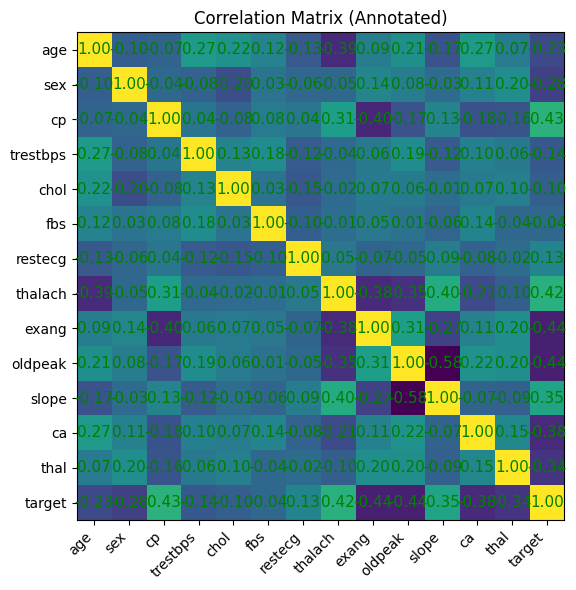

In [14]:
# ---------------------------
# 9) Figures
# ---------------------------
os.makedirs("figs", exist_ok=True)

# 9.1 Correlation matrix (annotated with values)
corr_cols = numeric_cols + ([target] if target not in numeric_cols else [])
corr = df[corr_cols + ([] if len(categorical_cols) > 0 else [])].corr(numeric_only=True)

plt.figure(figsize=(7, 6))
im = plt.imshow(corr, interpolation="nearest")
# plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right", fontsize=10)
plt.yticks(range(len(corr.index)), corr.index, fontsize=10)
plt.title("Correlation Matrix (Annotated)", fontsize=12)

# annotate values
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr.iloc[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=11, color="Green")
plt.tight_layout()
plt.savefig("figs/correlation_matrix_annotated.png", dpi=150)

# Helper: plot combined confusion matrices (Train & Test) in one figure
def plot_confusions(ytr, ytr_pred, yte, yte_pred, title, path, cell_fontsize=16, title_fontsize=14):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, (y_true, y_pred, split_name) in zip(
        axes, [(ytr, ytr_pred, "Train"), (yte, yte_pred, "Test")]
    ):
        cm = confusion_matrix(y_true, y_pred)
        im = ax.imshow(cm)
        ax.set_title(split_name, fontsize=title_fontsize)
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        ax.set_xticklabels(["Pred 0", "Pred 1"], fontsize=11)
        ax.set_yticklabels(["True 0", "True 1"], fontsize=11)
        for (i, j), v in np.ndenumerate(cm):
            ax.text(j, i, str(v), ha="center", va="center",
                    color="Green", fontsize=cell_fontsize, fontweight="bold")
    fig.suptitle(title, fontsize=title_fontsize+2)
    fig.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close(fig)

# Helper: combined ROC (Train & Test) in one figure for a single model
def plot_rocs(ytr, ytr_proba, yte, yte_proba, name, path, title_fontsize=14, legend_fontsize=11):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Train ROC
    RocCurveDisplay.from_predictions(ytr, ytr_proba[:, 1], name=f"{name} (Train)", ax=axes[0])
    axes[0].set_title("Train ROC", fontsize=title_fontsize)
    axes[0].legend(fontsize=legend_fontsize)
    # Test ROC
    RocCurveDisplay.from_predictions(yte, yte_proba[:, 1], name=f"{name} (Test)", ax=axes[1])
    axes[1].set_title("Test ROC", fontsize=title_fontsize)
    axes[1].legend(fontsize=legend_fontsize)
    fig.suptitle(f"ROC Curves — {name}", fontsize=title_fontsize+2)
    fig.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close(fig)

# 9.2 Combined Confusion Matrices (FFNN & ELM)
plot_confusions(y_train, ytr_ffnn_pred, y_test, yte_ffnn_pred,
                title="Confusion Matrices — FFNN (Train & Test)",
                path="figs/confusions_ffnn_train_test.png",
                cell_fontsize=18)

plot_confusions(y_train, ytr_elm_pred, y_test, yte_elm_pred,
                title="Confusion Matrices — ELM (Train & Test)",
                path="figs/confusions_elm_train_test.png",
                cell_fontsize=18)

# 9.3 Combined ROC Curves (FFNN & ELM)
plot_rocs(y_train, ytr_ffnn_proba, y_test, yte_ffnn_proba,
          name="FFNN", path="figs/roc_ffnn_train_test.png")

plot_rocs(y_train, ytr_elm_proba, y_test, yte_elm_proba,
          name="ELM", path="figs/roc_elm_train_test.png")
